# Optiver Realized Volatility Predictions Using TabNet

## The Competition

In this competition we're tasked with creating models to predict short term volatility for different stocks. The dataset includes book and trade data for different time buckets for each stock.
Our target is realized volatility of the given stock for the next 10 minute window. To compare our predictions with the actual test set we're going to use RMSPE (Root Mean Squared Percentage Error)

For the basic features and simple feature engineering you can take a look at the [competition data page](https://www.kaggle.com/c/optiver-realized-volatility-prediction/data) and [tutorial notebook](https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data) by the competition hosts, they are really useful!

Most of the features I'm going to use are common throughout the public notebooks and discussions. You can check the most important ones in the great notebooks by [@A.Sato](https://www.kaggle.com/tommy1028/lightgbm-starter-with-feature-engineering-idea) and [@Martin](https://www.kaggle.com/ragnar123/optiver-realized-volatility-lgbm-baseline)! The rest of the features are handpicked by me around several discussions and notebooks, thanks to all community!

## TabNet

Released by Google Research in 2019, Attentive Interpretable Tabular Learning (aka TabNet) is basically a type of neural network using attention mechanism (sequential attention to be exact) on tabular data to learn and make predictions. It aims to combine explainability of tree based models and high performance of the neural networks.

### Basic Architecture

![From TabNet Paper](https://i.imgur.com/lYbF5d4.png)

TabNet encoder composed of a feature transformer, an attentive transformer and feature masking. A split block takes and divides the preprocessed representation to be used by attentive transformer in subsequent step as well as overall output which we get through aggregating masks. This process continues by number of steps, each step composed of attentive transformer, mask, feature transformer and splits. Number of steps is a hyperparameter where we can experiment on it. Each step will have their own weight at the final classification.

Feature transformer is a multi layer network (including FC, BN and GRU's) some of these layers will be shared across every step while some of them are treated locally. The number of independent and shared layers are hyperparameter too and will have effect on your final predictions.

Once features has been preprocessed and transformed they passed into the attentive transformer and mask. Attentive Transformer includes a FC, BN and Sparsemax Normalization. So this block gains the information by using prior scales. In this step model learns how much each feature has been used before the current decision step. With mask model focuses on the important features and uses them.

Enough details I guess, in short we can use full power of the neural networks while keeping the explainability which is pretty important for tabular data.

Let's get started!

# Importing Libraries

In [1]:
!pip -q install ../input/pytorchtabnet/pytorch_tabnet-3.1.1-py3-none-any.whl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.matlib

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from scipy import stats
from scipy.stats import norm
from joblib import Parallel, delayed

import shutil
import glob

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts


# setting some globl config

plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'


import warnings
warnings.filterwarnings("ignore")

In [3]:
import psutil
psutil.cpu_count()

2

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sat Aug 28 05:33:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading Data

In [5]:
def read_train_test():
    # Function to read our base train and test set
    
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    print(f'Our test set has {test.shape[0]} rows')
    print(f'Our training set has {train.isna().sum().sum()} missing values')
    print(f'Our test set has {test.isna().sum().sum()} missing values')
    
    return train, test

In [6]:
train, test = read_train_test()

Our training set has 428932 rows
Our test set has 3 rows
Our training set has 0 missing values
Our test set has 0 missing values


# Preprocessing the Data

In [7]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

def calc_wap1(df):
    # Function to calculate first WAP
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    # Function to calculate second WAP
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(series):
    # Function to calculate the log of the return
    return np.log(series).diff()

def realized_volatility(series):
    # Calculate the realized volatility
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    # Function to count unique elements of a series
    return len(np.unique(series))

def book_preprocessor(file_path):
    # Function to preprocess book data (for each stock id)
    
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Function to get group stats for different windows (seconds in bucket)
        
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__400', 'time_id__300', 'time_id__200'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    return df_feature


def trade_preprocessor(file_path):
    # Function to preprocess trade data (for each stock id)
    
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, realized_volatility, np.mean, np.std, np.max, np.min],
        'order_count':[np.mean,np.sum,np.max],
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Function to get group stats for different windows (seconds in bucket)
        
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__400', 'time_id__300', 'time_id__200','time_id'], axis = 1, inplace = True)
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    
    def order_sum(df, sec:str):
        new_col = 'size_tau' + sec
        bucket_col = 'trade_seconds_in_bucket_count_unique' + sec
        df[new_col] = np.sqrt(1/df[bucket_col])
        
        new_col2 = 'size_tau2' + sec
        order_col = 'trade_order_count_sum' + sec
        df[new_col2] = np.sqrt(1/df[order_col])
        
        if sec == '400_':
            df['size_tau2_d'] = df['size_tau2_400'] - df['size_tau2']
        

    
    for sec in ['','_200','_300','_400']:
        order_sum(df_feature, sec)
        
    df_feature['size_tau2_d'] = df_feature['size_tau2_400'] - df_feature['size_tau2']
    
    return df_feature


def get_time_stock(df):
    # Function to get group stats for the stock_id and time_id
    
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    
    return df

def create_agg_features(train, test):

    # Making agg features

    train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')
    corr = train_p.corr()
    ids = corr.index
    kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
    l = []
    for n in range(7):
        l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )

    mat = []
    matTest = []
    n = 0
    for ind in l:
        newDf = train.loc[train['stock_id'].isin(ind) ]
        newDf = newDf.groupby(['time_id']).agg(np.nanmean)
        newDf.loc[:,'stock_id'] = str(n)+'c1'
        mat.append ( newDf )
        newDf = test.loc[test['stock_id'].isin(ind) ]    
        newDf = newDf.groupby(['time_id']).agg(np.nanmean)
        newDf.loc[:,'stock_id'] = str(n)+'c1'
        matTest.append ( newDf )
        n+=1

    mat1 = pd.concat(mat).reset_index()
    mat1.drop(columns=['target'],inplace=True)
    mat2 = pd.concat(matTest).reset_index()
    
    mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
    
    mat1 = mat1.pivot(index='time_id', columns='stock_id')
    mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
    mat1.reset_index(inplace=True)
    
    mat2 = mat2.pivot(index='time_id', columns='stock_id')
    mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
    mat2.reset_index(inplace=True)
    
    prefix = ['log_return1_realized_volatility', 'total_volume_mean', 'trade_size_mean', 'trade_order_count_mean','price_spread_mean','bid_spread_mean','ask_spread_mean',
              'volume_imbalance_mean', 'bid_ask_spread_mean','size_tau2']
    selected_cols=mat1.filter(regex='|'.join(f'^{x}.(0|1|3|4|6)c1' for x in prefix)).columns.tolist()
    selected_cols.append('time_id')
    
    train_m = pd.merge(train,mat1[selected_cols],how='left',on='time_id')
    test_m = pd.merge(test,mat2[selected_cols],how='left',on='time_id')
    
    # filling missing values with train means

    features = [col for col in train_m.columns.tolist() if col not in ['time_id','target','row_id']]
    train_m[features] = train_m[features].fillna(train_m[features].mean())
    test_m[features] = test_m[features].fillna(train_m[features].mean())

    return train_m, test_m
    
    
def preprocessor(list_stock_ids, is_train = True):
    # Funtion to make preprocessing function in parallel (for each stock id)
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    
    return df

## Loding the and doing some feature engineering

In [8]:
# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()

# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()

# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Fill inf values
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)

# Aggregating some features
train, test = create_agg_features(train,test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 47.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


# Training

First we selecting columns for the training and test.

In [9]:
X = train.drop(['row_id', 'target', 'time_id'], axis = 1)
y = train['target']
X_test=test.copy()
X_test.drop(['time_id','row_id'], axis=1,inplace=True)

## Setting Loss and Metrics

In [10]:
def rmspe(y_true, y_pred):
    # Function to calculate the root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))
    


def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()

### Here we set categorical data and scale the numerical data. I noticed faster convergence with scaling even though paper implying preprocessing is not needed.

In [11]:
nunique = X.nunique()
types = X.dtypes

categorical_columns = []
categorical_dims =  {}

for col in X.columns:
    if  col == 'stock_id':
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        X_test[col] = l_enc.transform(X_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
        


cat_idxs = [ i for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

### Here we set TabNet parameters, you can go bigger and deeper models but in my experiences bigger the model is higher the overfitting chance you have.

In [12]:
tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    n_d = 16,
    n_a = 16,
    n_steps = 2,
    gamma = 2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    mask_type = "entmax",
    scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 42,
    verbose = 10
    
)

### Here we split our folds and train 5 different models for each fold. I went for bigger batch size for faster training, feel free to experiment with model parameters above and below you can update me in comments if you find something interesting?

In [13]:
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
# Create out of folds array
oof_predictions = np.zeros((X.shape[0], 1))
test_predictions = np.zeros(X_test.shape[0])
feature_importances = pd.DataFrame()
feature_importances["feature"] = X.columns.tolist()
stats = pd.DataFrame()
explain_matrices = []
masks_ =[]

for fold, (trn_ind, val_ind) in enumerate(kfold.split(X)):
    print(f'Training fold {fold + 1}')
    X_train, X_val = X.iloc[trn_ind].values, X.iloc[val_ind].values
    y_train, y_val = y.iloc[trn_ind].values.reshape(-1,1), y.iloc[val_ind].values.reshape(-1,1)


    clf =  TabNetRegressor(**tabnet_params)
    clf.fit(
      X_train, y_train,
      eval_set=[(X_val, y_val)],
      max_epochs = 200,
      patience = 50,
      batch_size = 1024*20, 
      virtual_batch_size = 128*20,
      num_workers = 4,
      drop_last = False,
      eval_metric=[RMSPE],
      loss_fn=RMSPELoss
      )
    
    saving_path_name = f"./fold{fold}"
    saved_filepath = clf.save_model(saving_path_name)
    
    explain_matrix, masks = clf.explain(X_val)
    explain_matrices.append(explain_matrix)
    masks_.append(masks[0])
    masks_.append(masks[1])
      
    oof_predictions[val_ind] = clf.predict(X_val)
    test_predictions+=clf.predict(X_test.values).flatten()/5
    feature_importances[f"importance_fold{fold}+1"] = clf.feature_importances_
    
    stats[f'fold{fold+1}_train_rmspe']=clf.history['loss']
    stats[f'fold{fold+1}_val_rmspe']=clf.history['val_0_rmspe']
    
print(f'OOF score across folds: {rmspe(y, oof_predictions.flatten())}')

Training fold 1
Device used : cuda
epoch 0  | loss: 305.64184| val_0_rmspe: 57.23746|  0:00:09s
epoch 10 | loss: 0.91579 | val_0_rmspe: 0.62269 |  0:01:42s
epoch 20 | loss: 0.28926 | val_0_rmspe: 0.2703  |  0:03:20s
epoch 30 | loss: 0.29178 | val_0_rmspe: 0.28758 |  0:04:57s
epoch 40 | loss: 0.25568 | val_0_rmspe: 0.27191 |  0:06:28s
epoch 50 | loss: 0.23586 | val_0_rmspe: 0.22847 |  0:08:03s
epoch 60 | loss: 0.22334 | val_0_rmspe: 0.22541 |  0:09:40s
epoch 70 | loss: 0.22316 | val_0_rmspe: 0.22319 |  0:11:15s
epoch 80 | loss: 0.21966 | val_0_rmspe: 0.21624 |  0:12:45s
epoch 90 | loss: 0.21838 | val_0_rmspe: 0.21593 |  0:14:21s
epoch 100| loss: 0.21477 | val_0_rmspe: 0.21299 |  0:15:58s
epoch 110| loss: 0.21228 | val_0_rmspe: 0.21125 |  0:17:29s
epoch 120| loss: 0.21122 | val_0_rmspe: 0.21255 |  0:19:04s
epoch 130| loss: 0.21081 | val_0_rmspe: 0.21219 |  0:20:40s
epoch 140| loss: 0.2092  | val_0_rmspe: 0.20969 |  0:22:15s
epoch 150| loss: 0.20869 | val_0_rmspe: 0.20788 |  0:23:47s
epoc

# Train RMSPE

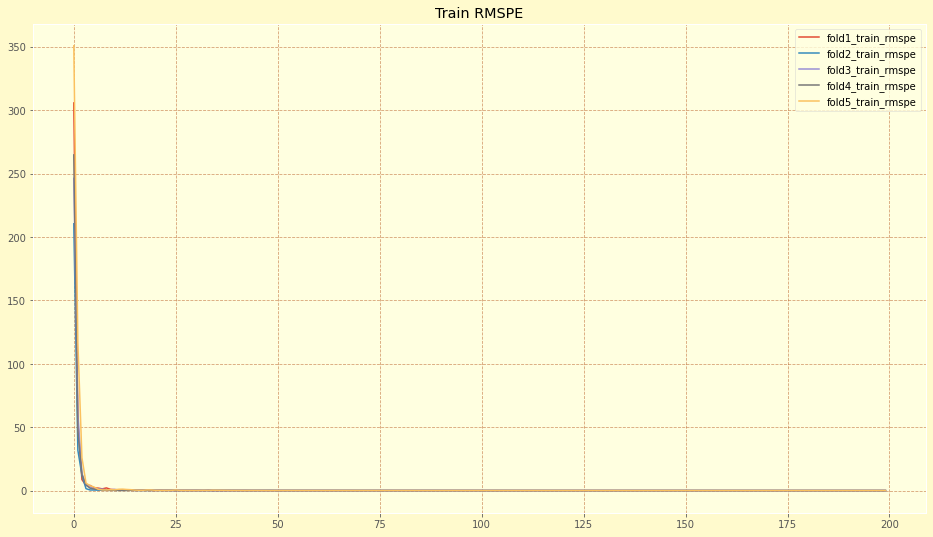

In [14]:
for i in stats.filter(like='train', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train RMSPE')
plt.legend()  

# Val RMSPE

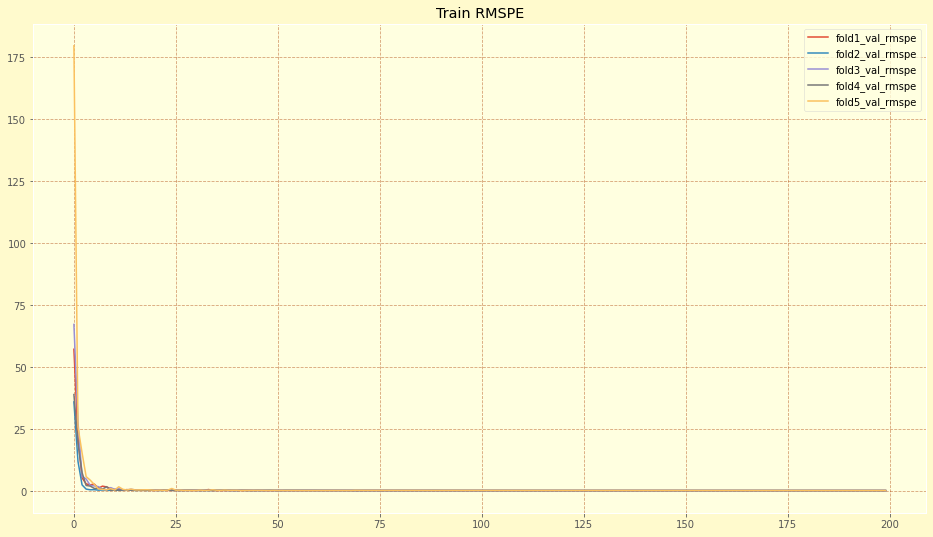

In [15]:
for i in stats.filter(like='val', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train RMSPE')
plt.legend() 

# Feature Importances

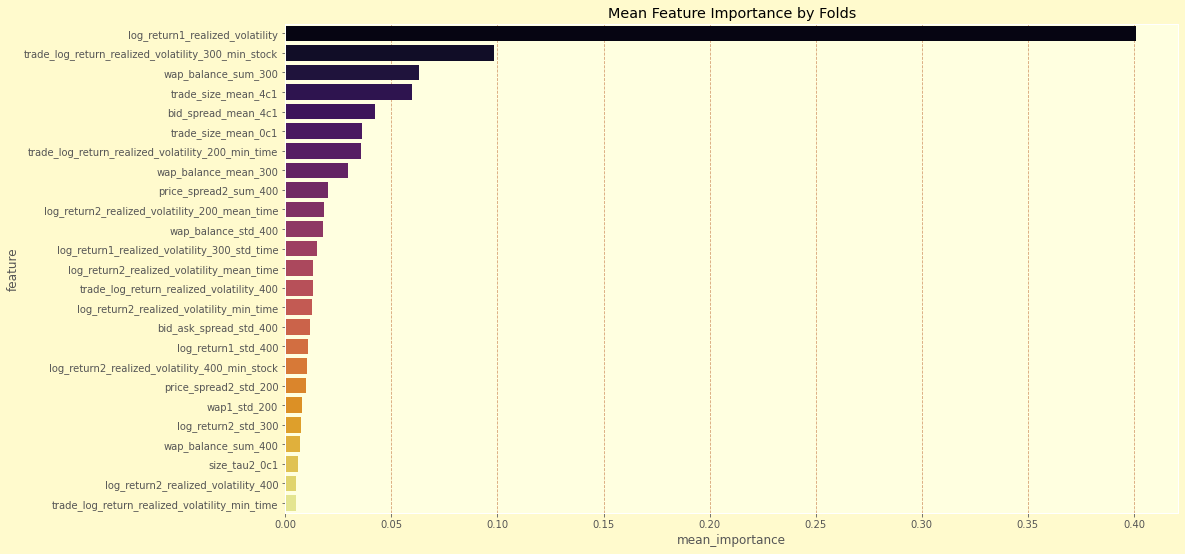

In [16]:
feature_importances['mean_importance']=feature_importances[['importance_fold0+1','importance_fold1+1']].mean(axis=1)
feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)
sns.barplot(y=feature_importances['feature'][:25],x=feature_importances['mean_importance'][:25], palette='inferno')
plt.title('Mean Feature Importance by Folds')
plt.show()

# Masks

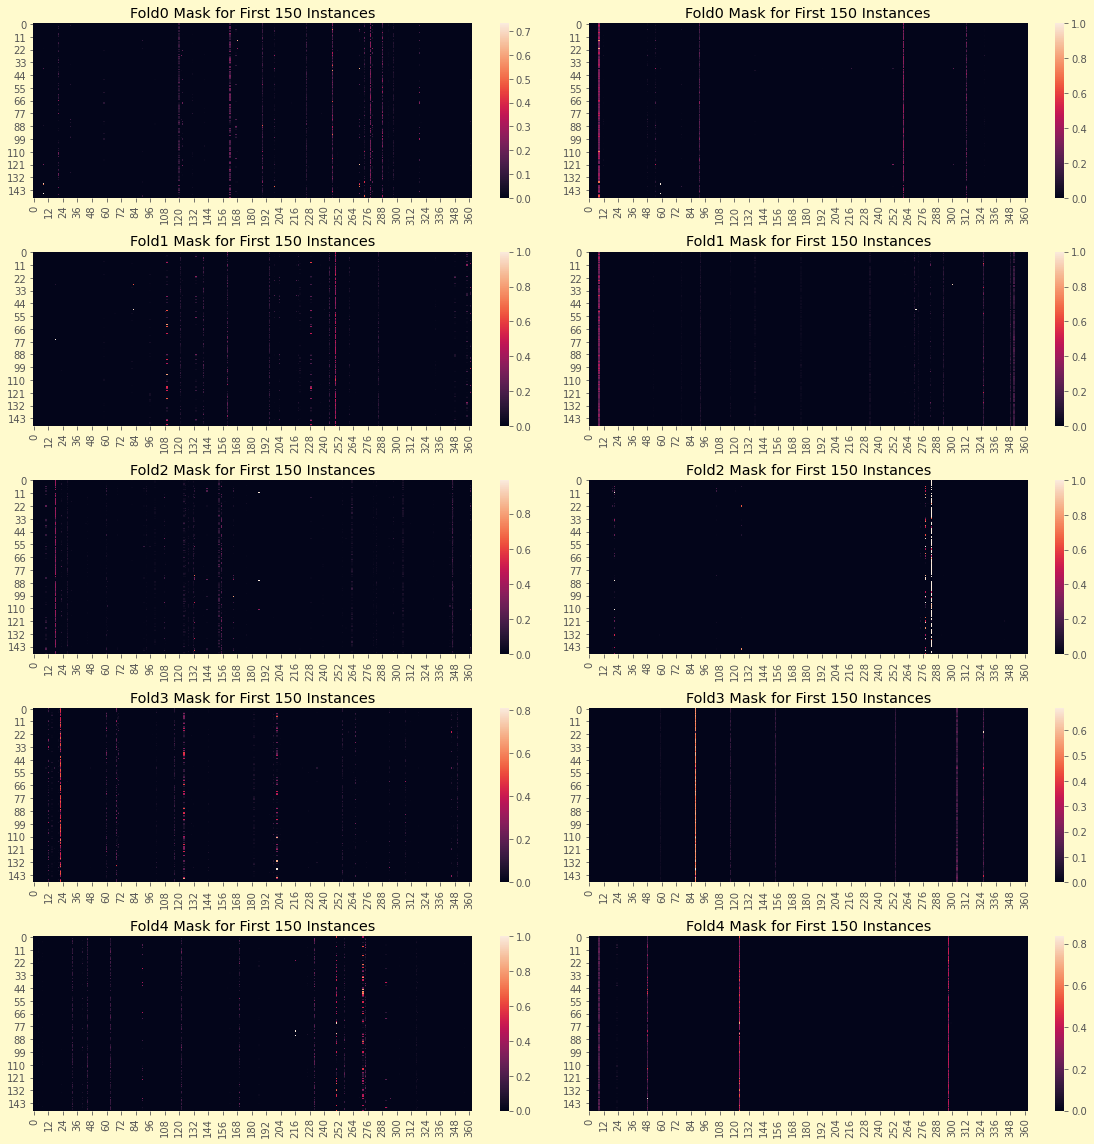

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(16,16))
axs = axs.flatten()

k=-1    
for i, (mask, j) in enumerate(zip(masks_, axs)):
    sns.heatmap(mask[:150], ax=j)
    if i%2 == 0:
        k+=1
    j.set_title((f"Fold{k} Mask for First 150 Instances"))
plt.tight_layout()

# Explain Matrices

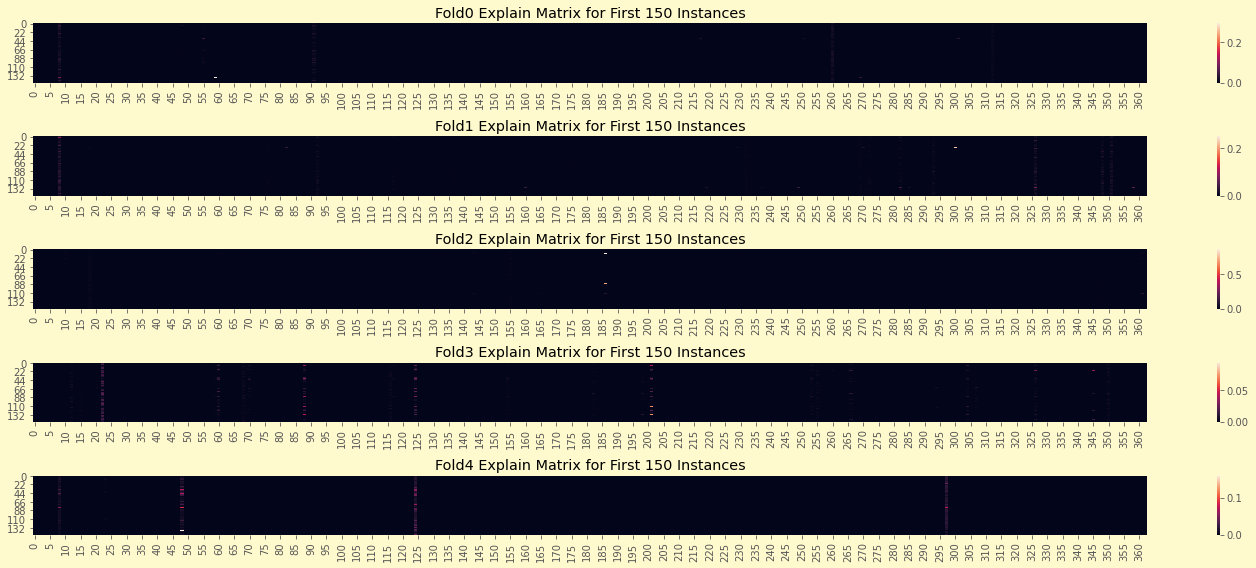

In [18]:
fig, axs = plt.subplots(len(explain_matrices), 1, figsize=(20,8))
for i,matrix in enumerate(explain_matrices):
    axs[i].set_title(f'Fold{i} Explain Matrix for First 150 Instances')
    sns.heatmap(matrix[:150], ax=axs[i])
plt.tight_layout() 
    

# Submission

In [19]:
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)